## NorSWE Data Processing ##

Raw data available at: https://zenodo.org/records/14503592

### Import Needed Packages ###

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import geopandas as gpd

### Define subsetting function ###

In [2]:
import numpy as np
import geopandas as gpd
import xarray as xr
import pandas as pd

def fast_subset_norswe(input_nc, vector_gpkg, output_nc=None):
    """
    Super‐fast spatial clip of NorSWE by a GPKG boundary, using positional indexing.
    Now preserves the 'source' string variable by writing with the h5netcdf engine.
    """
    # 1) Open with Dask chunks
    ds = xr.open_dataset(input_nc,
                         chunks={'time': 1000, 'station_id': 1000})

    # 2) Deduplicate time if needed
    time_index = pd.to_datetime(ds["time"].values)
    is_dup = time_index.duplicated(keep="first")

    if is_dup.any():
        dupe_times = time_index[is_dup].unique()
        mismatch_found = False

        for tm in dupe_times:
            all_inds = np.where(time_index == tm)[0]
            first_ind = all_inds[0]
            for idx in all_inds[1:]:
                for varname in ds.data_vars:
                    # ← Skip any variable that does NOT have a "time" dimension
                    if "time" not in ds[varname].dims:
                        continue

                    a = ds[varname].isel(time=first_ind).compute()
                    b = ds[varname].isel(time=idx).compute()
                    if not a.equals(b):
                        mismatch_found = True
                        print(
                            f"WARNING: data differ for variable '{varname}' "
                            f"at duplicate time {tm}. "
                            f"Indices {first_ind} vs {idx}. Dropping index {idx}."
                        )
                        break
                if mismatch_found:
                    break
            if mismatch_found:
                break

        mask = ~is_dup
        ds = ds.isel(time=mask)
        ds = ds.sortby("time")

    # 3) Pre‐filter by bounding box
    gdf = gpd.read_file(vector_gpkg).to_crs("EPSG:4326")
    minx, miny, maxx, maxy = gdf.total_bounds

    candidate_pos = np.where(
        (ds.lon >= minx) & (ds.lon <= maxx) &
        (ds.lat >= miny) & (ds.lat <= maxy)
    )[0]

    # 4) Build GeoDataFrame of candidates, carrying integer positions
    pts = gpd.GeoDataFrame(
        {'pos': candidate_pos},
        geometry=gpd.points_from_xy(
            ds.lon.values[candidate_pos],
            ds.lat.values[candidate_pos]
        ),
        crs="EPSG:4326"
    )

    # 5) Spatial join → pick the positions inside
    inside = gpd.sjoin(pts, gdf, predicate="intersects", how="inner")
    sel_pos = inside['pos'].values

    # 6) Subset by integer pos (station_id dimension)
    ds_sub = ds.isel(station_id=sel_pos)

    # 7) By default, keep all data_vars plus all coordinates
    #    (We only drop vars here if you explicitly list them in `to_drop`.)
    to_drop = []
    if to_drop:
        ds_sub = ds_sub.drop_vars(to_drop)

    # 8) Materialize & write with h5netcdf so that string vars are preserved
    if output_nc:
        ds_sub = ds_sub.load()
        ds_sub.to_netcdf(
            output_nc,
            engine='h5netcdf',
            format='NETCDF4'
        )

    return ds_sub


def export_station_metadata_to_csv(subset_ds, csv_path):
    """
    Writes station_id, lat, lon, and source to CSV.
    """
    df = pd.DataFrame({
        'station_id': subset_ds['station_id'].values,
        'lat':        subset_ds['lat'].values,
        'lon':        subset_ds['lon'].values,
        # ensure each entry is a native Python str
        'source':     [str(s) for s in subset_ds['source'].values]
    })
    df.to_csv(csv_path, index=False)

### Define paths

In [3]:
norswe_path = '/Users/dcasson/Data/snow_data/NorSWE/NorSWE-NorEEN_1979-2021_v3.nc'
output_dir = '/Users/dcasson/Data/snow_data/NorSWE'
norswe_csv_path = Path(output_dir) / 'NorSWE_station_metadata.csv'
bow_nc_path = Path(output_dir) / 'Bow_NorSWE.nc'    
bow_csv_path = Path(output_dir) / 'Bow_NorSWE.csv'
chena_nc_path = Path(output_dir) / 'Chena_NorSWE.nc'
chena_csv_path = Path(output_dir) / 'Chena_NorSWE.csv'
tuolumne_nc_path = Path(output_dir) / 'Tuolumne_NorSWE.nc'
tuolumne_csv_path = Path(output_dir) / 'Tuolumne_NorSWE.csv'

norswe_ds = xr.open_dataset(norswe_path)
var_list = ['source']
export_station_metadata_to_csv(norswe_ds, norswe_csv_path)





In [ ]:
bow_above_banff_boundary

In [11]:
var_list = []
bow_boundary = '/Users/dcasson/GitHub/PEMS/gis_data/bow/bow_boundary.gpkg'
chena_boundary = '/Users/dcasson/GitHub/PEMS/gis_data/chena/chena_boundary.gpkg'
tuolumne_boundary = '/Users/dcasson/GitHub/PEMS/gis_data/tuolumne/tuolumne_boundary.gpkg'

bow_ds = fast_subset_norswe(norswe_path, bow_boundary, bow_nc_path)
export_station_metadata_to_csv(bow_ds, bow_csv_path)

chena_ds = fast_subset_norswe(norswe_path, chena_boundary, chena_nc_path)
export_station_metadata_to_csv(chena_ds, chena_csv_path)

tuolumne_ds = fast_subset_norswe(norswe_path, tuolumne_boundary, tuolumne_nc_path)
export_station_metadata_to_csv(tuolumne_ds, tuolumne_csv_path)



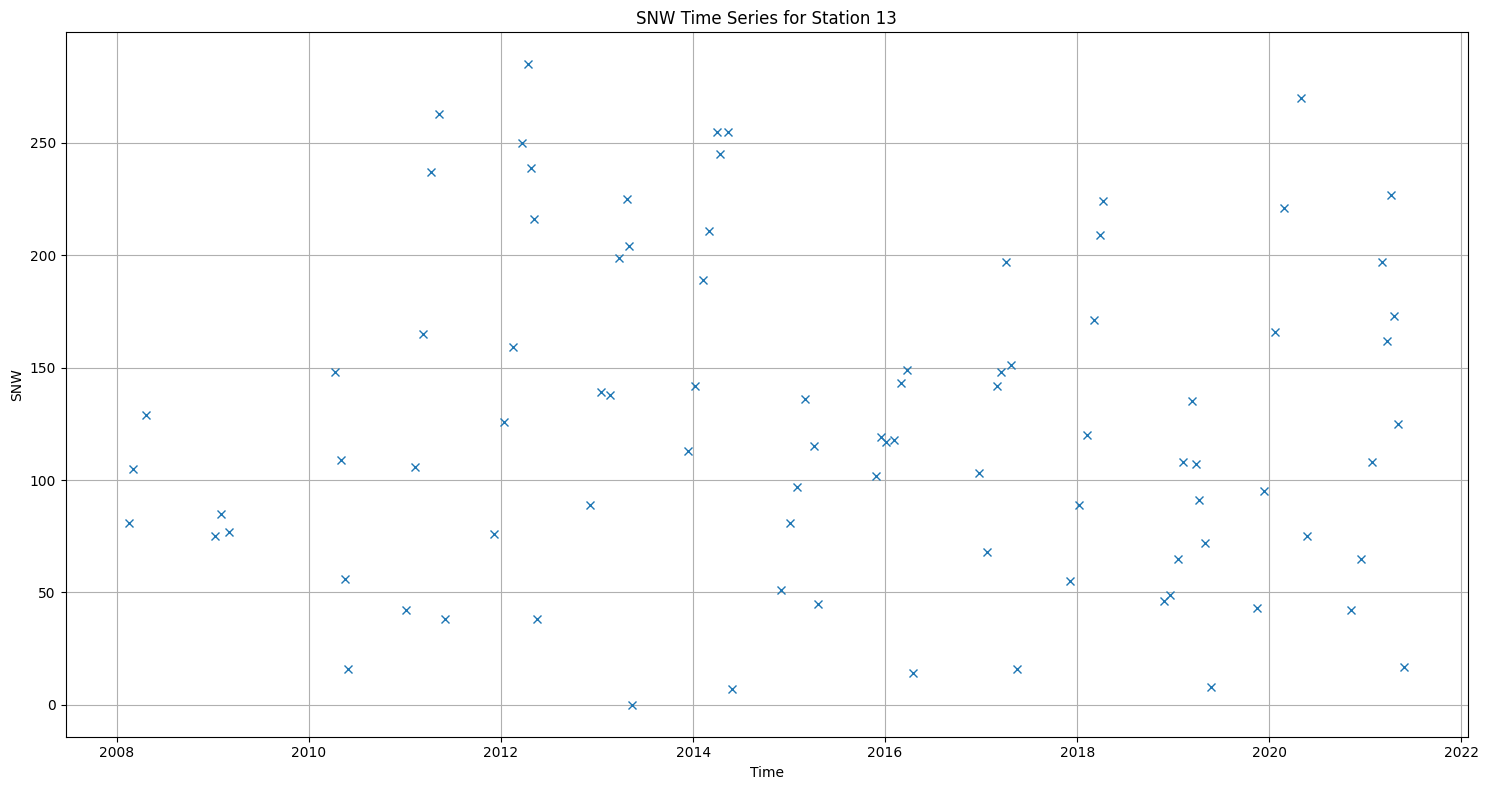

In [25]:
import matplotlib.pyplot as plt

def plot_station_timeseries(ds, var_name, station_idx):
    """
    Plot a time series for a specific variable and station using x markers
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing the data
    var_name : str
        Name of variable to plot (e.g. 'snw' or 'snd')
    station_idx : int
        Index of station to plot
    """
    station_data = ds.isel(station_id=station_idx)
    
    plt.figure(figsize=(15, 8))
    plt.plot(station_data.time, station_data[var_name], 'x', label=f'Station {station_idx+1}')
    
    plt.xlabel('Time')
    plt.ylabel(var_name.upper())
    plt.title(f'{var_name.upper()} Time Series for Station {station_idx+1}')
    plt.grid(True)
    plt.tight_layout()

# Example usage:
plot_station_timeseries(bow_ds, 'snw',12)  # Plot SWE for first station
# plot_station_timeseries(bow_ds, 'snd', 0)  # Plot snow depth for first station








